# Fibre Bend Tests

This is an older notebook for my MPhys project, this notebook mainly can show you my work relating to neural network optimisation and my general coding practise.

In [2]:
# Imports
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import random
import os
import IPython

import torch
import torch.nn as nn
from torch.nn import Parameter

from fibrefunctions import *

torch.set_printoptions(precision=10, threshold=10000, sci_mode=False)
plt.set_cmap('bwr')

# Importing Data - From USB
if os.path.exists("F:/venv code/Y3 Work/Fibres/MATLAB Files"):
    PIM_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Modes189.mat")
    modes = PIM_data["F2"].transpose(2,0,1) # Modes
    PIMs_torch = torch.tensor(modes, dtype=torch.cdouble)

    beta_data = sc.io.loadmat("F:/venv code/Y3 Work/Fibres/MATLAB Files/Beta189.mat")
    beta = beta_data["Beta"] # Phase velocities for each mode
    beta_torch = torch.tensor(beta, dtype=torch.double)

    uwlm = np.genfromtxt("F:/venv code/Y3 Work/Fibres/MATLAB Files/uwlm.txt", delimiter=",", skip_header=1)

    print("Files imported from USB.")

# Importing Data - From Kaggle
elif os.path.exists("/kaggle/input/fibre-data"):
    PIM_data = sc.io.loadmat("/kaggle/input/fibre-data/Modes.mat")
    modes = PIM_data["F2"].transpose(2,0,1) # Modes~
    PIMs_torch = torch.tensor(modes, dtype=torch.cfloat)

    beta_data = sc.io.loadmat("/kaggle/input/fibre-data/Beta.mat")
    beta = beta_data["Beta"] # Phase velocities for each mode
    beta_torch = torch.tensor(beta, dtype=torch.cfloat)

    print("Files imported from Kaggle database.")

else:
    print("No files found.")

# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

if torch.cuda.is_available():
    devNumber = torch.cuda.current_device()
    print(f"The current device number is {devNumber}")

    dev_name = torch.cuda.get_device_name(devNumber)
    print(f"GPU is {dev_name}")
else:
    print(f"No GPU available.")

Files imported from USB.
Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


<Figure size 640x480 with 0 Axes>

## Global Variables

In [4]:
wl = 633e-9 #[m]  # From MATLAB Code
no_pix = 31
mask_len = 25e-6 #[m]  # From MATLAB Code
pix_size = mask_len / no_pix

# Porting the PIM data to the GPU
#PIMs_torch = PIMs_torch.to(device)
#beta_torch = beta_torch.to(device)

# Functions
Extra functions created in this notebook, if they work correctly and are useful enough, they will be moved to the fibrefunctions.py folder

In [5]:
def zernike_array(j: str, alpha: torch.Tensor = 0.0, size = 31, wl: float = 633e-9, mask_len: float = 25e-6):
    """Creates an array based on either the tip or tilt zernike polynomial."""
    Nx = np.linspace(-0.5,0.5,size)
    Ny = np.linspace(-0.5,0.5,size)
    X,Y = np.meshgrid(Nx,Ny)
    X = torch.from_numpy(X) * mask_len
    Y = torch.from_numpy(Y) * mask_len

    if j in ('X','x'):
        alpha = torch.deg2rad(90-alpha)
        rho = X
        dist = rho * torch.cos(alpha)
        weight = torch.exp(1j * 2*np.pi/wl * dist)
    elif j in ('Y','y'):
        alpha = torch.deg2rad(alpha)
        rho = Y
        dist = rho * torch.sin(alpha)
        weight = torch.exp(1j * 2*np.pi/wl * dist)
    else:
        raise ValueError("j input not valid! Only accepts 'X' or 'Y'!")

    return weight

## Models

In [29]:
class LengthModel(nn.Module):
    """Class to propagate a field through a straight section of MMF, trains one parameter 'length'."""
    def __init__(self, length=0.21):
        super(LengthModel, self).__init__()
        # Parameters
        self.length = nn.Parameter(data=torch.tensor([length], dtype=torch.float32, requires_grad=True))
    
    def forward(self, input_field):
        """Forward pass of the model."""
        output_field = propagate(input_field, PIMs_torch, beta_torch, self.length)
        return output_field
    
class BendModel(nn.Module):
    """Class to apply a phase plane, representing a bend in the fibre, to a field."""
    def __init__(self, angle=0.0):
        super(BendModel, self).__init__()

        self.wl = 633e-9 #[m]  # From MATLAB Code
        self.mask_len = 25e-6 #[m]  # From MATLAB Code
        # Parameters
        self.angle = nn.Parameter(data=torch.tensor([angle], dtype=torch.float32, requires_grad=True))
    
    def forward(self, input_field, j:str):
        """Forward pass of the model."""
        prop_field = propagate(input_field, PIMs_torch, beta_torch, 0.1)
        bend_field = apply_zernike(prop_field, j, self.angle, self.wl, self.mask_len)
        output_field = propagate(bend_field, PIMs_torch, beta_torch, 0.1)
        return output_field

class BendModel2(nn.Module):
    """Class to apply 2 phase planes, representing a bend in the fibre, to a field."""
    def __init__(self, anglex=0.0, angley=0.0):
        super(BendModel2, self).__init__()

        self.wl = 633e-9 #[m]  # From MATLAB Code
        self.mask_len = 25e-6 #[m]  # From MATLAB Code
        # Parameters
        self.anglex = nn.Parameter(data=torch.tensor([anglex], dtype=torch.float32, requires_grad=True))
        self.angley = nn.Parameter(data=torch.tensor([angley], dtype=torch.float32, requires_grad=True))
    
    def forward(self, input_field):
        """Forward pass of the model."""
        prop_field = propagate(input_field, PIMs_torch, beta_torch, 0.1)
        bend_field = apply_zernike(prop_field, 'x', self.anglex, self.wl, self.mask_len)
        bend_field = apply_zernike(bend_field, 'y', self.angley, self.wl, self.mask_len)
        output_field = propagate(bend_field, PIMs_torch, beta_torch, 0.1)
        return output_field

class BendModelN(nn.Module):
    """Class to model a field propagation through an MMF with n number of bends."""
    def __init__(self, angles: np.ndarray=np.zeros((1,2)), prop_len: float=0.1):
        super(BendModelN, self).__init__()

        self.N = angles.shape[0]
        self.wl = 633e-9 #[m]  # From MATLAB Code
        self.mask_len = 25e-6 #[m]  # From MATLAB Code
        self.prop_len = prop_len
        # Parameters
        self.angles = nn.Parameter(data=angles.clone().detach(), requires_grad=True)
    
    def forward(self, input_field):
        """Forward pass of the model."""
        endsegment_field = input_field
        # For n bends, propagate and apply bends for each segment
        for i in range(self.N):
            prop_field = propagate(endsegment_field, PIMs_torch, beta_torch, self.prop_len)
            bend_field = apply_zernike(prop_field, 'x', self.angles[i,0], self.wl, self.mask_len)
            endsegment_field = apply_zernike(bend_field, 'y', self.angles[i,1], self.wl, self.mask_len)
        # After all bends, propagate one more time
        output_field = propagate(endsegment_field, PIMs_torch, beta_torch, self.prop_len)
        return output_field

## Functions

In [ ]:
def plot_loss_length(n, dist, l_bound, u_bound, num_points):
    """Plots the loss function.
    n = Number of PIMs
    dist = Propagation distance [m]
    l_bound, u_bound = Lower and upper bounds for the loss plot
    num_points = Number of points used in the loss plot"""
    
    model = LengthModel(dist)

    fields_in = PIMs_torch[0:n]

    fields_target = []
    for i in range(n):
        fields_target.append(model(fields_in[i]))

    # Plot loss function using the target data
    loss = []
    xs = torch.from_numpy(np.linspace(l_bound, u_bound, num_points))

    for i in range(xs.size()[0]):
        model = LengthModel(xs[i])
        fields_out = []
    
        for j in range(n):
            fields_out.append(model(fields_in[j]))
    
        loss.append(loss_func(fields_out, fields_target).cpu().detach().numpy())

        if i % 10 == 0:
            print(f"[{i}/{num_points}]")
            IPython.display.clear_output(wait=True)

    plt.plot(xs,loss)
    plt.grid(visible=True)
    plt.ylabel("Loss")
    plt.xlabel("Length [m]")
    plt.title(f"Loss Function (True Length = {dist}$^o$)")

    return 0

def plot_loss_bend(n, alpha, j:str, l_bound, u_bound, num_points):
    """Plots the loss function.
    n = Number of PIMs
    alpha = Bend Angle [deg]
    j = x or y for different zernike mode
    l_bound, u_bound = Lower and upper bounds for the loss plot
    num_points = Number of points used in the loss plot"""
    
    xs, loss = loss_bend(n, alpha, j, l_bound, u_bound, num_points)

    plt.plot(xs,loss)
    plt.grid(visible=True)
    plt.ylabel("Loss")
    plt.xlabel("Angle [degrees]")
    plt.title(f"Loss Function (True Angle = {alpha}$^o$)")

    return 0


def loss_bend(n, alpha, j:str, l_bound, u_bound, num_points):
    """Calculates the loss depending on angle for the loss function.
    n = Number of PIMs
    alpha = Bend Angle [deg]
    j = x or y for different zernike mode
    l_bound, u_bound = Lower and upper bounds for the loss plot
    num_points = Number of points used in the loss plot"""
    
    model = BendModel(alpha)

    fields_in = PIMs_torch[0:n]

    fields_target = []
    for i in range(n):
        fields_target.append(model(fields_in[i], j))

    # Plot loss function using the target data
    loss = []
    xs = torch.from_numpy(np.linspace(l_bound, u_bound, num_points))

    for i in range(xs.size()[0]):
        model = BendModel(xs[i])
        fields_out = []
    
        for k in range(n):
            fields_out.append(model(fields_in[k], j))
    
        loss.append(loss_func(fields_out, fields_target).cpu().detach().numpy())

        #if i % 10 == 0:
        print(f"[{i}/{num_points}]")
        IPython.display.clear_output(wait=True)

    return xs, loss

def interp(xdata, ydata):
    """Adds a new point between all existing points in the data, using linear interpolation. Assumes the xdata is all evenly spaced."""
    # Find the number of points to interpolate
    num_points = len(xdata) - 1
    
    # Find the x points to plot for
    interpx = []
    for i in range(num_points):
        interpx.append(xdata[i] + (xdata[i+1]-xdata[i])/2)

    # Interpolate
    interpy = np.interp(interpx, xdata, ydata)

    return interpx, interpy

In [8]:
def interp_arr(A, B):
    """Returns a new, linearly interpolated, array between arrays A and B."""
    return np.linspace(A,B,3)[1]

def interp_loss(alpha, j:str, l_bound, u_bound, num_points):
    """Function generates interpolated field data to plot a loss function with."""
    model = BendModel(alpha)

    field_in = PIMs_torch[0]
    field_target = model(field_in, j)

    # Plot loss function using the target data
    loss = []
    angles = []
    xs = torch.from_numpy(np.linspace(l_bound, u_bound, num_points))

    for i in range(xs.size()[0]):
        print(f"[{i}/{num_points}]")
        IPython.display.clear_output(wait=True)
        # Want to find the i and i+1 fields
        if i+1 < xs.size()[0]:
            model = BendModel(xs[i])
            field1 = model(field_in, j)
            model = BendModel(xs[i+1])
            field2 = model(field_in, j)

            # Linear interpolate between 2 fields
            field_interp = interp_arr(field1.detach(), field2.detach())

            # Make plotting data
            angles.append(xs[i])
            angles.append(xs[i] + (xs[i+1]-xs[i])/2)
            loss.append(loss_func_single(field1, field_target).cpu().detach().numpy())
            loss.append(loss_func_single(torch.from_numpy(field_interp), field_target).cpu().detach().numpy())
        else:
            model = BendModel(xs[i])
            field1 = model(field_in, j)
            angles.append(xs[i])
            loss.append(loss_func_single(field1, field_target).cpu().detach().numpy())
    
    return angles, loss

def compare_interp(alpha, j:str, l_bound, u_bound, num_points):
    """Function plots 3 graphs: Original plot, Interpolated Plot, Actual Plot for same number of interpolated points"""
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    fig.suptitle(r"Interpolated Loss Function Comparison (True angle: $\alpha$="+str(alpha)+")", fontsize=18)
    # =================================================
    # First Subplot - Original Loss Function
    # =================================================
    xs, loss = loss_bend(1, alpha, j, l_bound, u_bound, num_points)
    axs[0].plot(xs, loss)
    axs[0].set_xlabel("Angle [degrees]"), axs[0].set_ylabel("Loss"), axs[0].set_title(f"Loss Function, {num_points} Data Points"), axs[0].grid(visible=True)
    print("1/3")
    # =================================================
    # Second Subplot - Interpolated Loss Function
    # =================================================
    angles, loss = interp_loss(alpha, j, l_bound, u_bound, num_points)
    axs[1].plot(angles, loss)
    axs[1].set_xlabel("Angle [degrees]"), axs[1].set_ylabel("Loss"), axs[1].set_title(f"Interpolated Loss Function, {2*num_points} Data Points"), axs[1].grid(visible=True)
    print("2/3")
    # =================================================
    # Third Subplot - Actual Loss Function, 2x points
    # =================================================
    angles, loss = loss_bend(1, alpha, j, l_bound, u_bound, 2*num_points)
    axs[2].plot(angles, loss)
    axs[2].set_xlabel("Angle [degrees]"), axs[2].set_ylabel("Loss"), axs[2].set_title(f"Loss Function, {2*num_points} Data Points"), axs[2].grid(visible=True)
    print("3/3")

3/3


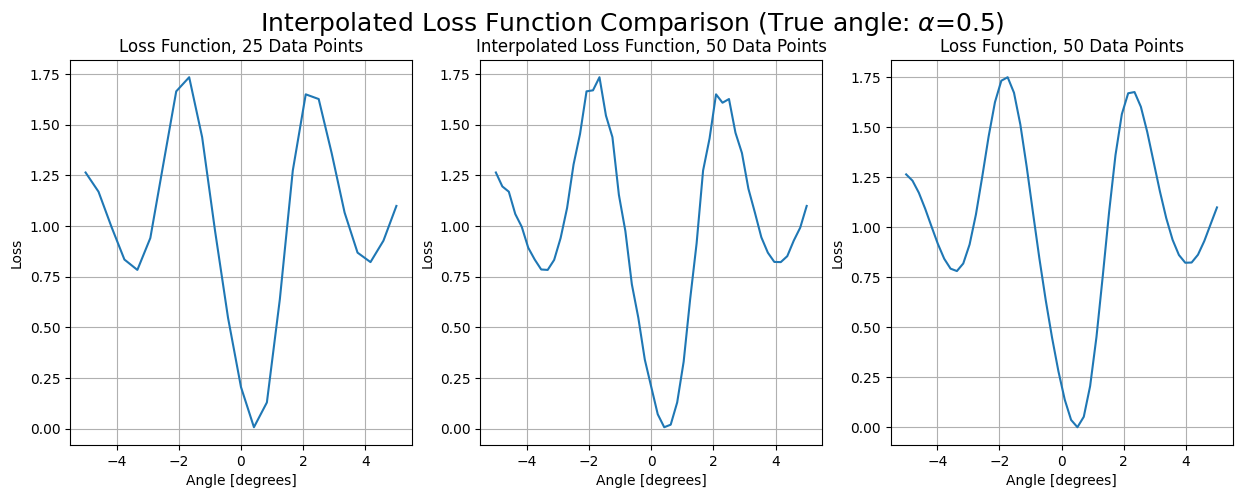

In [6]:
compare_interp(0.5, 'x', -5, 5, 25)

no


31


f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


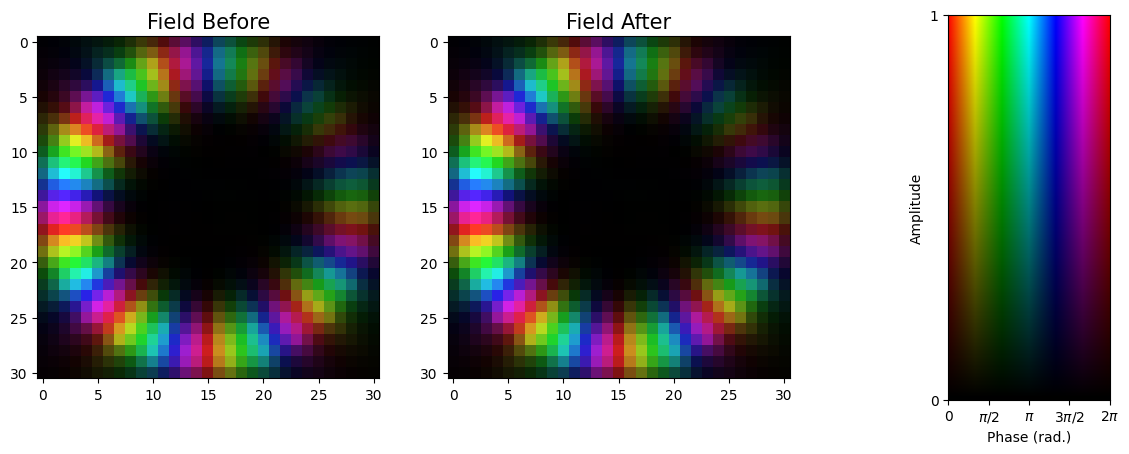

In [75]:
a1,b1,c1 = loss_bend(1, 0.5, 'x', -5,5,25)
a2,b2,c2 = interp_loss(0.5, 'x', -5,5,25)

if c1 == c2:
    print("yes")
else:
    print("no")

print(len(c2))
visualise2(c1[0].detach(), c2.detach())

### Testing Propagation
Without model first

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


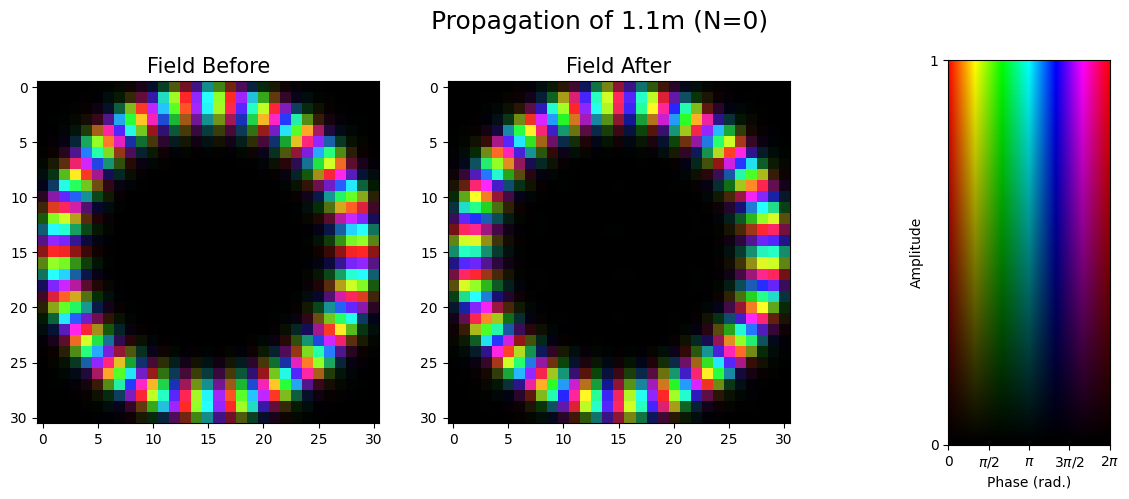

In [16]:
field_in = PIMs_torch[0]
field_out = propagate(field_in, PIMs_torch, beta_torch, 1.1)

visualise2(field_in, field_out, "Propagation of 1.1m (N=0)")

In [6]:
print(f"Phase Velocity of mode 19: {beta_torch[0].item()} m/s")
print(f"Phase change should be: {np.angle(np.exp(1j*beta_torch[0].item()*1.1))} radians")

Phase Velocity of mode 19: 14429030.114878625 m/s
Phase change should be: -2.4285439432250615 radians


Test using a model

In [7]:
#plot_loss_length(1, 1.1, 1.09, 1.11, 1001)
#plot_loss_length(10, 1.1, 1.09, 1.11, 1001)
#plot_loss_length(42, 1.1, 1.09, 1.11, 1001)

In [8]:
# Make training data from a 42 fields
input_data = PIMs_torch#.to(device)
prop_dist = 1.1
model = LengthModel(1.1)

target_data = []
for i in range(input_data.shape[0]):
    target_data.append(model(input_data[i]).detach())

print(input_data.shape)
print(np.array(target_data).shape)

torch.Size([42, 31, 31])
(42, 31, 31)


Epoch 0, Loss: 1.2285771396281544, length: 1.0999009609222412

Final Loss: 1.7811574090468643
Final length: 1.0992273092269897


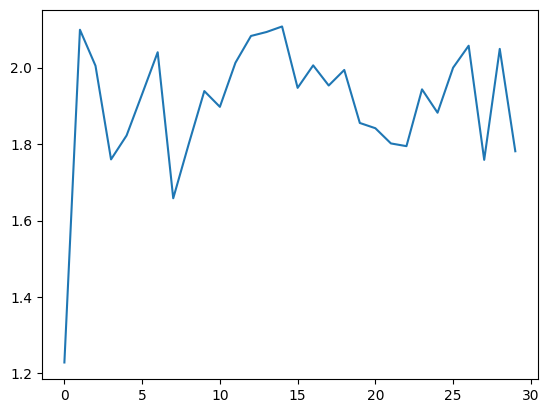

In [9]:
# Training Loop
model = LengthModel(1.1+1e-6)#.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 30
epoch_list = []
loss_list = []

for epoch in range(epochs):
    optimiser.zero_grad()

    output_data = []
    for i in range(input_data.shape[0]):
        output_data.append(model(input_data[i]))
        
    loss = loss_func(output_data, target_data)
    loss.backward()
    optimiser.step()

    epoch_list.append(epoch)
    loss_list.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, length: {model.length.item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final length: {model.length.item()}")

plt.plot(epoch_list, loss_list)

In [10]:
# https://stackoverflow.com/questions/49558753/ipython-jupyter-notebook-clear-only-one-line-of-output
#IPython.display.display_javascript(r'''
#    var el = document.querySelector('.output_text:last-of-type > pre');
#    el.innerHTML = el.innerHTML.replace(/(\n.*$)/gm,""); ''', raw=True)

### Testing Bending

0

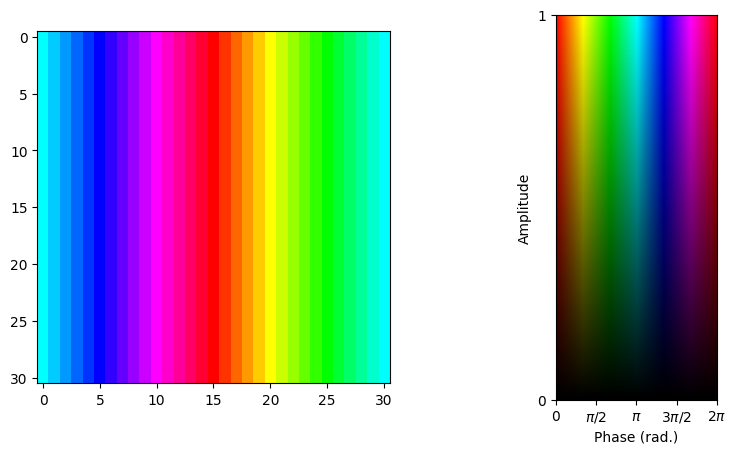

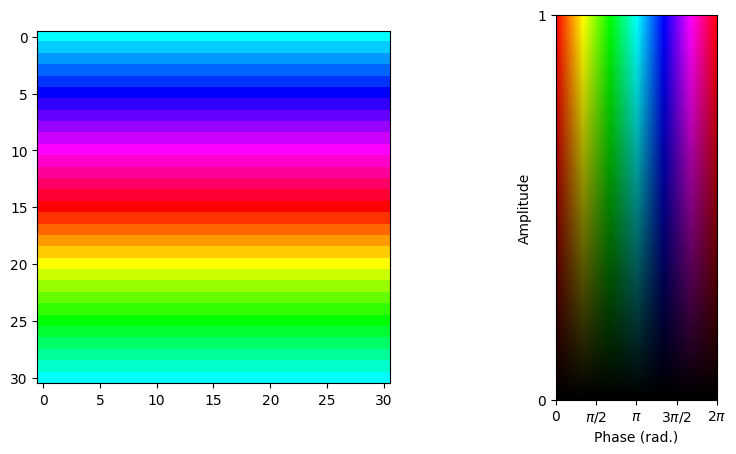

In [6]:
zernike_vis(31,'x',torch.tensor([1.4509]))
zernike_vis(31,'y',torch.tensor([1.4509]))

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


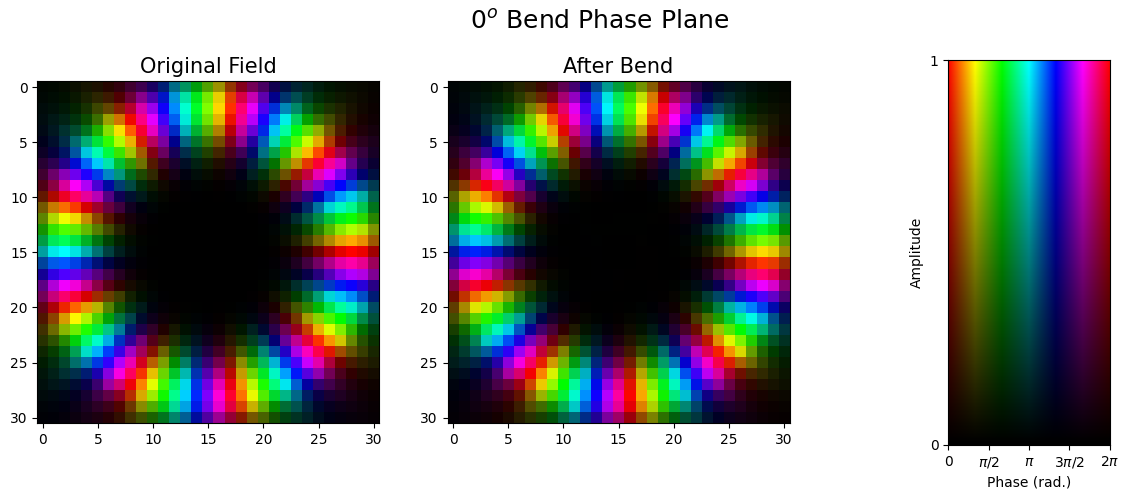

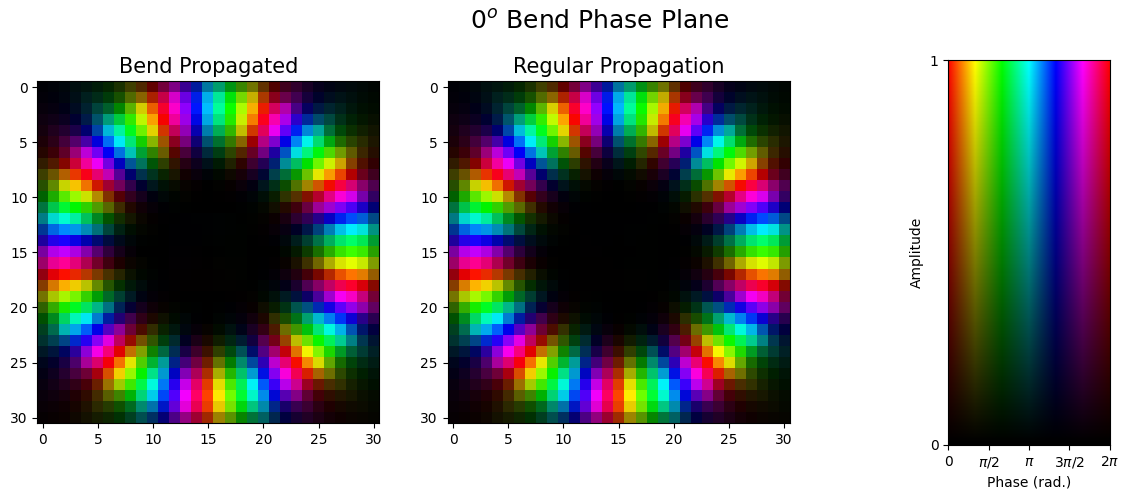

In [7]:
# Check if a bend of 0 degrees agrees with regular propagation
alpha = torch.tensor([0.0])
field_in = PIMs_torch[0]
field_prop1 = propagate(field_in, PIMs_torch, beta_torch, 0.1)
field_out = apply_zernike(field_prop1, 'y', alpha)
field_prop2 = propagate(field_out, PIMs_torch, beta_torch, 0.1)
# Just regular propagation for 0.2m
reg_prop = propagate(field_in, PIMs_torch, beta_torch, 0.2)

visualise2(field_in, field_out, "$0^o$ Bend Phase Plane", "Original Field", "After Bend")
visualise2(field_prop2, reg_prop, "$0^o$ Bend Phase Plane", "Bend Propagated", "Regular Propagation")

In [13]:
field_in = PIMs_torch[0]
model = BendModel(1.5)
field_out = model(field_in, 'x')
#visualise(field_out.detach())

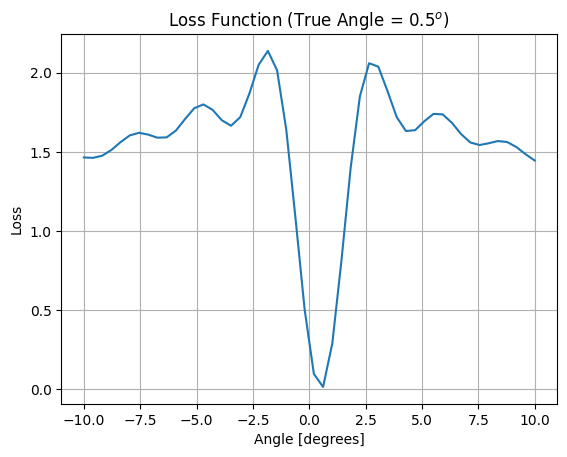

In [8]:
#plot_loss_bend(1, 0.5, 'x', -180, 210, 2001)
#plot_loss_bend(10, 0.5, 'x', -60, 60, 1001)
#plot_loss_bend(42, 0.5, 'x', -10, 10, 501)
plot_loss_bend(189,0.5,'x',-10,10,50)

In [16]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [17]:
output.detach().item()

2.536942481994629

In [18]:
a = []
print(a)
for i in range(10):
    a.append(i)
print(a)
a = np.array(a)
a = torch.from_numpy(a)
print(type(a))

[]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
<class 'torch.Tensor'>


In [19]:
#Model
model = BendModel(0.5)
# Input field
field_in = PIMs_torch[0]
# Target Field
target_field = model(field_in,'x').detach()

Epoch 0, Loss: 0.03325421609019592, length: 1.4900000095367432
Epoch 100, Loss: 0.0010710211257539983, length: 0.667253851890564
Epoch 200, Loss: 1.4866317009484748e-06, length: 0.5063056945800781
Epoch 300, Loss: 1.602378452780648e-12, length: 0.5000098347663879
Epoch 400, Loss: 0.0, length: 0.49999722838401794

Final Loss: 0.0
Final length: 0.49999722838401794


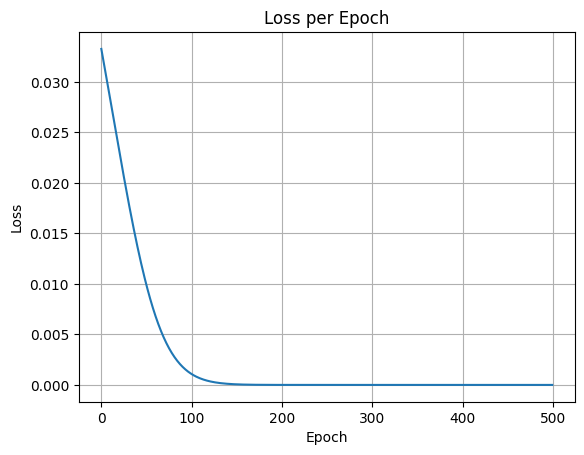

In [20]:
# Training Loop
model = BendModel(1.5)#.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)
#loss_function = nn.MSELoss()

epochs = 500
epoch_list = []
loss_list = []

for epoch in range(epochs):
    optimiser.zero_grad()
    # Make output data
    field_out = model(field_in,'x')
    # Compute loss
    loss = loss_func(field_out, target_field)
    # Backwards pass
    loss.backward()
    optimiser.step()

    epoch_list.append(epoch)
    loss_list.append(loss.detach().item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, length: {model.angle.item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final length: {model.angle.item()}")

plt.plot(epoch_list, loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.grid(visible=True)

torch.Size([42, 31, 31])
torch.Size([10, 31, 31])
torch.Size([10, 31, 31])
Epoch 0, Loss: 0.9910303985939606, length: 1.4900000095367432
Epoch 100, Loss: 0.03459803222846743, length: 0.6637879014015198
Epoch 200, Loss: 7.320783742563558e-06, length: 0.5022941827774048
Epoch 300, Loss: 5.712353978249417e-11, length: 0.499990314245224
Epoch 400, Loss: 0.0, length: 0.4999999403953552

Final Loss: 0.0
Final length: 0.4999999403953552


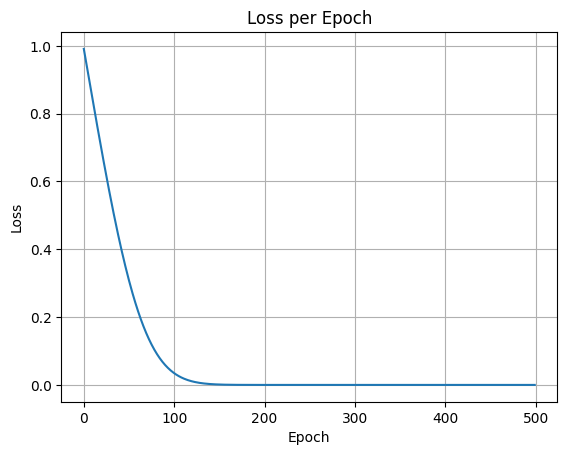

In [21]:
# Model
model = BendModel(0.5)

# Input fields
n = 10 # Number of fields
fields_in = PIMs_torch[0:n]

print(PIMs_torch.shape)
print(fields_in.shape)

# Target fields
fields_target = []
for i in range(n):
    target = model(fields_in[i],'x').detach()
    fields_target.append(target)
fields_target = np.array(fields_target)
fields_target = torch.from_numpy(fields_target)

print(fields_target.shape)

# Training loop
model = BendModel(1.5)#.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 500
epoch_list = []
loss_list = []

for epoch in range(epochs):
    optimiser.zero_grad()
    
    # Make output data
    fields_out = []
    for i in range(n):
        output = model(fields_in[i],'x')
        fields_out.append(output)
    #fields_out = np.array(fields_out)
    #fields_out = torch.from_numpy(fields_out)

    # Compute loss
    loss = loss_func(fields_out, fields_target)
    # Backwards pass
    loss.backward()
    optimiser.step()

    epoch_list.append(epoch)
    loss_list.append(loss.detach().item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, length: {model.angle.item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final length: {model.angle.item()}")

plt.plot(epoch_list, loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.grid(visible=True)

## Bending with x and y tilt

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


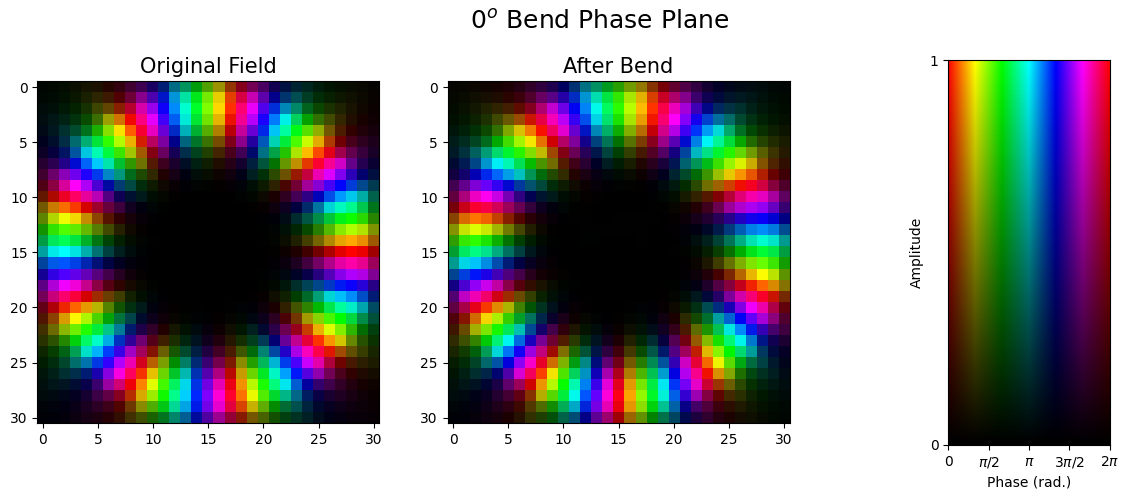

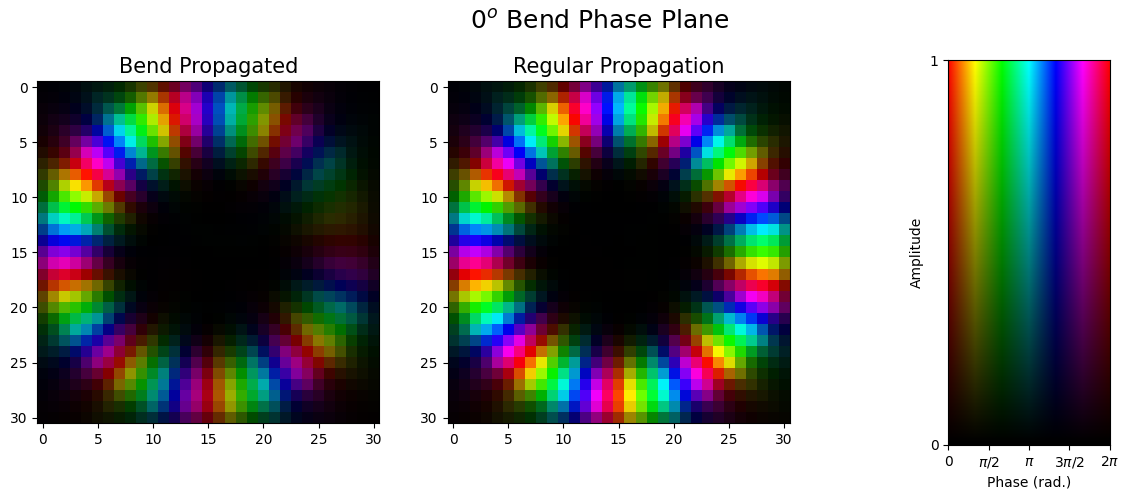

In [8]:
# Check if a bend of 0 degrees agrees with regular propagation
alpha = torch.tensor([0.75])
beta = torch.tensor([0.3])
field_in = PIMs_torch[0]
field_prop1 = propagate(field_in, PIMs_torch, beta_torch, 0.1)
field_out = apply_zernike(field_prop1, 'x', alpha)
field_out = apply_zernike(field_out, 'y', beta)
field_prop2 = propagate(field_out, PIMs_torch, beta_torch, 0.1)
# Just regular propagation for 0.2m
reg_prop = propagate(field_in, PIMs_torch, beta_torch, 0.2)

visualise2(field_in, field_out, "$0^o$ Bend Phase Plane", "Original Field", "After Bend")
visualise2(field_prop2, reg_prop, "$0^o$ Bend Phase Plane", "Bend Propagated", "Regular Propagation")

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


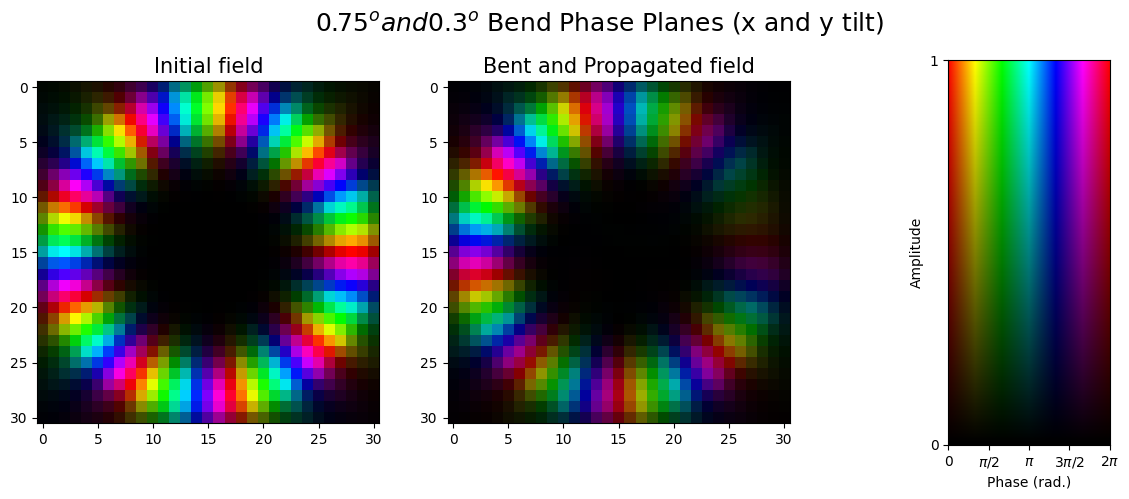

In [9]:
alpha = 0.75
beta = 0.3
model = BendModel2(alpha, beta)

field_in = PIMs_torch[0]
field_out = model(field_in)

visualise2(field_in, field_out.detach(), "$0.75^o and 0.3^o$ Bend Phase Planes (x and y tilt)", "Initial field", "Bent and Propagated field")

In [ ]:
def plot_bendxy_loss(n, alpha, beta, l_bound, u_bound, num_points=100):
    """Returns a surface plot of the loss for a bend with both an x and y component.
    n = Number of Input Fields
    alpha, beta = Bend angles for x and y tilt respectively
    l_bound, u_bound = Lower and Upper bound for the grid
    num_points = Number of points on one axis of the grid (default is 100x100)"""

    # Compute loss for n fields
    model = BendModel2(alpha, beta)
    fields_in = PIMs_torch[:n]

    # Make target fields
    fields_target = []
    for i in range(n):
        fields_target.append(model(fields_in[i]).detach())
    fields_target = np.array(fields_target)
    fields_target = torch.from_numpy(fields_target)

    # Have a 100x100 surface plot for loss where x,y = alpha,beta and z = loss
    xs = np.linspace(l_bound, u_bound, num_points)
    ys = np.linspace(l_bound, u_bound, num_points)
    xs, ys = np.meshgrid(xs, ys)
    xs = torch.from_numpy(xs)
    ys = torch.from_numpy(ys)

    # Compute the loss for each point on the grid
    loss = np.empty(xs.shape)
    loss[:] = np.nan
    for i in range(xs.shape[0]):
        print(f"[{i}/{num_points}]")
        IPython.display.clear_output(wait=True)

        for j in range(xs.shape[0]):
            model = BendModel2(xs[i,j],ys[i,j])
            
            # Make output data
            fields_out = []
            for k in range(n):
                fields_out.append(model(fields_in[k]).detach())
            fields_out = np.array(fields_out)
            fields_out = torch.from_numpy(fields_out)
            
            loss[i,j] = loss_func(fields_out, fields_target).cpu().detach().numpy()

    fig = plt.figure(figsize=(20,5))
    fig.suptitle(r"Loss Function (True angles: $\alpha$="+str(alpha)+r", $\beta$="+ str(beta)+")", fontsize=18)
    # ================
    # First Subplot
    # ================
    ax = fig.add_subplot(1, 4, 1, projection='3d')
    surf = ax.plot_surface(xs,ys,loss, cmap=cm.jet)
    ax.set_title("Regular View")
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$\beta$")
    ax.set_zlabel("Loss")
    # ================
    # Directional Subplots
    # ================
    # z # top-down
    ax = fig.add_subplot(1, 4, 2, projection='3d')
    surf = ax.plot_surface(xs,ys,loss, cmap=cm.jet)
    fig.colorbar(surf, shrink=0.4, aspect=10)
    ax.view_init(elev=90, azim=0, roll=0)
    ax.zaxis.set_ticklabels([])
    ax.set_title("Top-down View")
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$\beta$")
    # x
    ax = fig.add_subplot(1, 4, 3, projection='3d')
    surf = ax.plot_surface(xs,ys,loss, cmap=cm.jet)
    fig.colorbar(surf, shrink=0.4, aspect=10)
    ax.view_init(elev=0, azim=0, roll=0)
    ax.xaxis.set_ticklabels([])
    ax.set_title(r"Side On View ($\beta$)")
    ax.set_ylabel(r"$\beta$")
    ax.set_zlabel("Loss")
    # y
    ax = fig.add_subplot(1, 4, 4, projection='3d')
    surf = ax.plot_surface(xs,ys,loss, cmap=cm.jet)
    fig.colorbar(surf, shrink=0.4, aspect=10)
    ax.view_init(elev=0, azim=-90, roll=0)
    ax.yaxis.set_ticklabels([])
    ax.set_title(r"Side On View ($\alpha$)")
    ax.set_xlabel(r"$\alpha$")
    ax.set_zlabel("Loss")

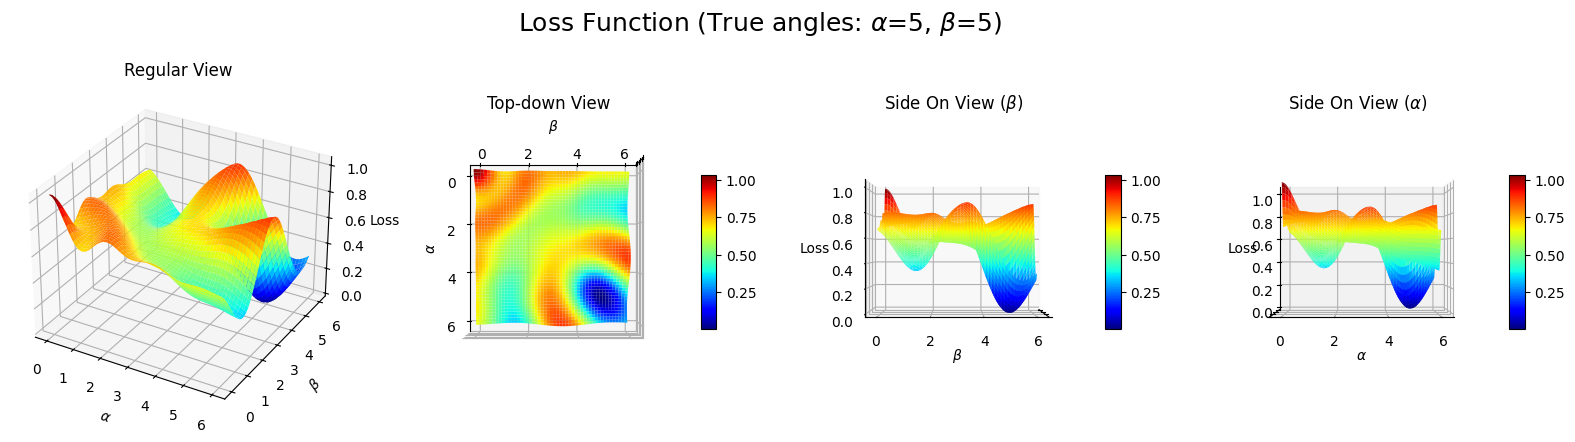

In [ ]:
plot_bendxy_loss(1, 5, 5, 0, 6, 250)

Epoch 0, Loss: 1.1345412990931656, Alpha: 0.009999996051192284, Beta: 0.009999995119869709
Epoch 100, Loss: 1.0766604451473578, Alpha: 0.9523349404335022, Beta: 0.9523335695266724
Epoch 200, Loss: 0.7839808792488305, Alpha: 2.4350953102111816, Beta: 2.4350953102111816
Epoch 300, Loss: 0.7828980007138119, Alpha: 2.499814033508301, Beta: 2.4998161792755127
Epoch 400, Loss: 0.7828979744286374, Alpha: 2.4994869232177734, Beta: 2.499495029449463

Final Loss: 0.7828979744286374
Final Alpha: 2.4994869232177734
Final Beta: 2.499495029449463


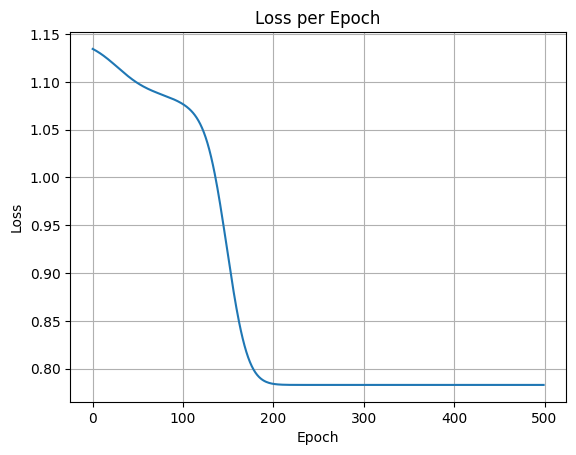

In [13]:
# Angles
alpha, beta = 5, 5
# Model
model = BendModel2(alpha, beta)

# Input fields
n = 42 # Number of fields
fields_in = PIMs_torch[:n]

# Make target fields
fields_target = []
for i in range(n):
    fields_target.append(model(fields_in[i]).detach())
fields_target = np.array(fields_target)
fields_target = torch.from_numpy(fields_target)

# Training loop
model = BendModel2(0, 0)#.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 500
epoch_list = []
loss_list = []

for epoch in range(epochs):
    optimiser.zero_grad()
    
    # Make output data
    fields_out = []
    for k in range(n):
        fields_out.append(model(fields_in[k]))
    #fields_out = np.array(fields_out)
    #fields_out = torch.from_numpy(fields_out)

    # Compute loss
    loss = loss_func(fields_out, fields_target)
    # Backwards pass
    loss.backward()
    optimiser.step()

    epoch_list.append(epoch)
    loss_list.append(loss.detach().item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Alpha: {model.anglex.item()}, Beta: {model.angley.item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final Alpha: {model.anglex.item()}")
print(f"Final Beta: {model.angley.item()}")

plt.plot(epoch_list, loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.grid(visible=True)

f:\venv code\.venv\lib\site-packages\matplotlib\colors.py:3174: RuntimeWarning: invalid value encountered in cast
  i = (h * 6.0).astype(int)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..8.017797776187254e+289].


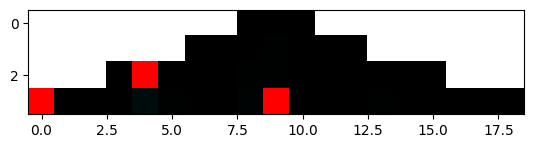

In [162]:
u,w,l,p = np.hsplit(uwlm,4)

field = PIMs_torch[0] + PIMs_torch[5] + PIMs_torch[22]
test = pim_matrix(PIMs_torch) @ vectorise(norm(field))
test = torch.flip(test, [0, 1])

p_range = int(p.max() - p.min() + 1)
l_range = int(l.max() - l.min() + 1)

mat = np.zeros((p_range, l_range))
mat[:] = np.nan
mat = torch.from_numpy(mat).to(dtype=torch.cdouble)

for i in range(l.shape[0]):
    i_index = 9 + int(l[i,0])
    j_index = int(p[i,0])
    mat[j_index, i_index] = test[i,0]
mat = torch.flipud(mat)

#visualise(mat)
plt.imshow(Complex2HSV(mat))

f:\venv code\.venv\lib\site-packages\matplotlib\colors.py:3174: RuntimeWarning: invalid value encountered in cast
  i = (h * 6.0).astype(int)


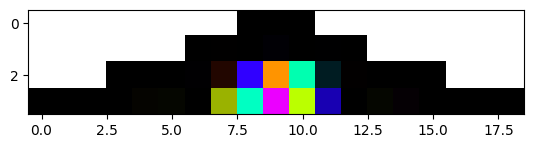

In [171]:
field_in = norm(PIMs_torch[22])
model = BendModel2(0.5,0.5)
field_out = model(field_in).detach().numpy()
#plt.imshow(Complex2HSV(field_in))
#plt.imshow(Complex2HSV(field_out))

u,w,l,p = np.hsplit(uwlm,4)
field_out = torch.from_numpy(field_out)
test = pim_matrix(PIMs_torch) @ vectorise(norm(field_out))
test = torch.flip(test, [0, 1])

p_range = int(p.max() - p.min() + 1)
l_range = int(l.max() - l.min() + 1)

mat = np.zeros((p_range, l_range))
mat[:] = np.nan
mat = torch.from_numpy(mat).to(dtype=torch.cdouble)

for i in range(l.shape[0]):
    i_index = 9 + int(l[i,0])
    j_index = int(p[i,0])
    mat[j_index, i_index] = test[i,0]
mat = torch.flipud(mat)

#visualise(mat)
plt.imshow(Complex2HSV(mat))

In [140]:
test = torch.tensor([[1+1j,2],[-1,4+5j]], dtype=torch.cdouble)
rad = torch.abs(test)
max_rad = torch.max(rad)
norm_rad = rad/max_rad
angle = test.angle()

norm_rad*(torch.cos(angle) + 1j*torch.sin(angle))

tensor([[ 0.1561737619+0.1561737619j,  0.3123475238+0.0000000000j],
        [-0.1561737619+0.0000000000j,  0.6246950476+0.7808688094j]],
       dtype=torch.complex128)

In [6]:
def norm(mat):
    """Normalises a given complex matrix so that radii are between values of 0 and 1, while maintaining the angles."""
    rad = torch.abs(mat)
    max_rad = torch.max(rad)
    norm_rad = rad/max_rad
    angle = mat.angle()

    return norm_rad*(torch.cos(angle) + 1j*torch.sin(angle))

In [25]:
def Complex2HSV_test(z, intensity: bool=False):
    """Finds the magnitude and angle of a complex number and uses it to find a hsv colour value.
    Returns the equivalent RGB value for matplotlib.pyplot.
    If intensity = True, returns an intensity plot, if false (default) returns the regular amplitude plot."""
    # get amplidude of z and limit to [rmin, rmax]
    z = norm(z)
    amp = np.abs(z)
    amp = np.where(amp < 0, 0, amp)
    amp = np.where(amp > 1, 1, amp)
    phase = np.angle(z, deg=1)
    # HSV are values in range [0,1]
    h = (phase % 360) / 360
    s = np.ones_like(h)
    if intensity == 1:
        v = amp**2
    else:
        v = amp
    return hsv_to_rgb(np.dstack((h,s,v)))

def visualise_test(field, title="", intensity: bool=False):
    """Displays a visual plot of the field, using hsv colour mapping to demonstrate the fields phase (Hue) and amplitude (Value)."""
    # Set up plots
    fig, axs = plt.subplots(1,2, figsize=(10,5))
        
    # Plot the given field
    if field.is_cuda == True:
        axs[0].imshow(Complex2HSV_test(field.cpu(), intensity))
    else:
        axs[0].imshow(Complex2HSV_test(field, intensity))

    # Colour bar
    V, H = np.mgrid[0:1:100j, 0:1:300j]
    S = np.ones_like(V)
    HSV = np.dstack((H,S,V))
    RGB = hsv_to_rgb(HSV)

    axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

    axs[1].set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', '$\pi/2$', '$\pi$', '$3\pi/2$','$2\pi$'])
    axs[1].set_yticks([0, 1], ['0', '1'])

    axs[1].set_ylabel("Amplitude")
    axs[1].set_xlabel("Phase (rad.)")
    fig.suptitle(title, fontsize=16)

    #fig.show()

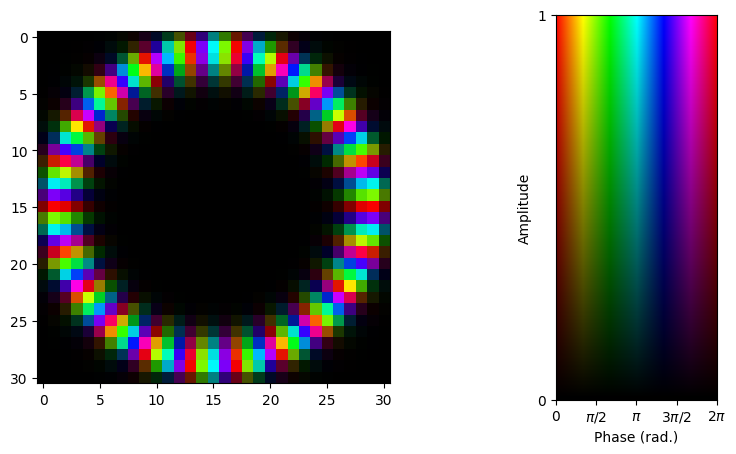

In [9]:
field = PIMs_torch[0]
visualise(field)

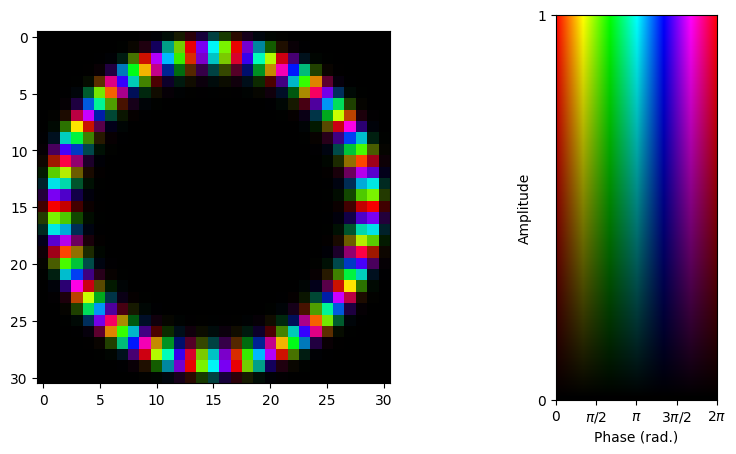

In [10]:
field = PIMs_torch[0]
visualise(field, intensity=True)

torch.Size([31, 31]) torch.ComplexDoubleTensor


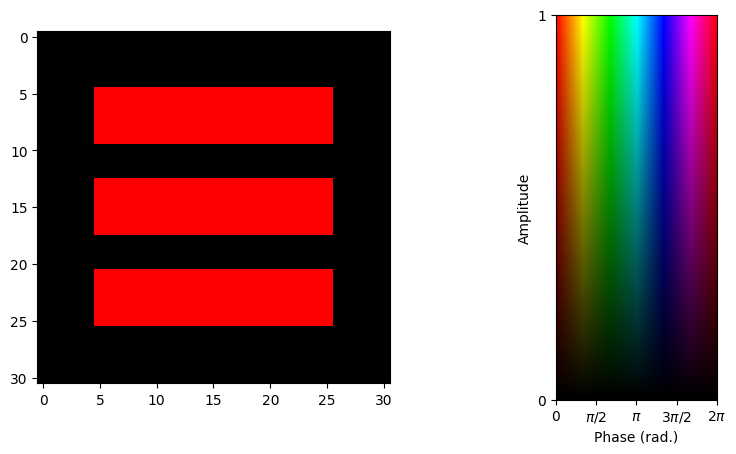

In [24]:
im = plt.imread("Images\\3 hlines.png")
im_torch = torch.from_numpy(1 - im)[:,:,0]
im_torch = im_torch.to(dtype=torch.cdouble)
print(im_torch.shape, im_torch.type())
#plt.imshow(Complex2HSV(im_torch))
visualise(im_torch)

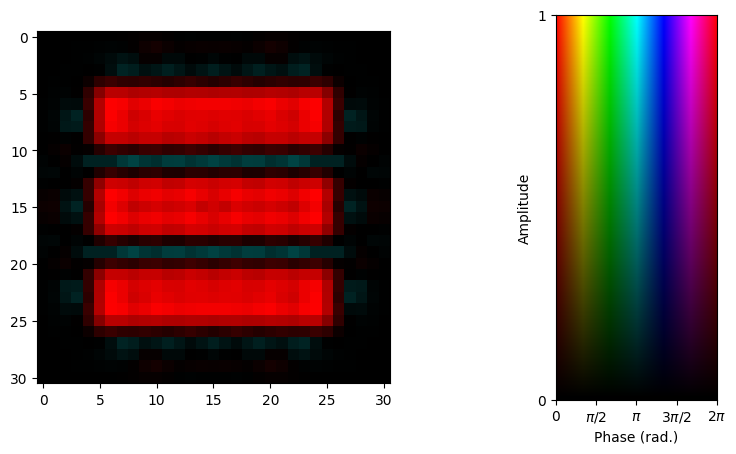

In [25]:
pim_im = propagate(im_torch, PIMs_torch, beta_torch)
visualise(pim_im)

# Alter bend model to work for n number of bends

In [48]:
class BendModelN(nn.Module):
    """Class to model a field propagation through an MMF with n number of bends."""
    def __init__(self, angles: np.ndarray=np.zeros((1,2)), prop_len: float=0.1):
        super(BendModelN, self).__init__()

        self.N = angles.shape[0]
        self.wl = 633e-9 #[m]  # From MATLAB Code
        self.mask_len = 25e-6 #[m]  # From MATLAB Code
        self.prop_len = prop_len
        # Parameters
        self.angles = nn.Parameter(data=torch.tensor(angles, dtype = torch.float32, requires_grad=True))
    
    def forward(self, input_field):
        """Forward pass of the model."""
        endsegment_field = input_field
        # For n bends, propagate and apply bends for each segment
        for i in range(self.N):
            prop_field = propagate(endsegment_field, PIMs_torch, beta_torch, self.prop_len)
            bend_field = apply_zernike(prop_field, 'x', self.angles[i,0], self.wl, self.mask_len)
            endsegment_field = apply_zernike(bend_field, 'y', self.angles[i,1], self.wl, self.mask_len)
        # After all bends, propagate one more time
        output_field = propagate(endsegment_field, PIMs_torch, beta_torch, self.prop_len)
        return output_field

In [70]:
# Angles
angles = np.array([[2,2],[2,2],[2,2]])
# Model
model = BendModelN(angles)

# Input fields
n = 5 # Number of fields
fields_in = PIMs_torch[:n]

# Make target fields
fields_target = []
for i in range(n):
    fields_target.append(model(fields_in[i]).detach())
fields_target = np.array(fields_target)
fields_target = torch.from_numpy(fields_target)

print(fields_in.shape)
print(fields_target.shape)

torch.Size([5, 31, 31])
torch.Size([5, 31, 31])


Epoch 0, Loss: 1.323818684670964, Bend 1: (-0.009999997913837433, -0.009999996982514858), Bend 2: (0.009999999776482582, 0.009999998845160007), Bend 3: (-0.009999996982514858, -0.009999997913837433)
Epoch 50, Loss: 1.0350653479384477, Bend 1: (-0.3710334002971649, -0.4504118263721466), Bend 2: (0.38411545753479004, 0.38565680384635925), Bend 3: (-0.5133316516876221, -0.41101446747779846)
Epoch 100, Loss: 1.0088207504923663, Bend 1: (-0.4470634460449219, -0.29972273111343384), Bend 2: (0.20028719305992126, 0.3901221454143524), Bend 3: (-0.7498281002044678, -0.48681575059890747)
Epoch 150, Loss: 0.9238245933848465, Bend 1: (-0.2529829144477844, 0.05427410826086998), Bend 2: (0.10058949142694473, 0.7541996240615845), Bend 3: (-1.0753074884414673, -0.3045557141304016)
Epoch 200, Loss: 0.8460826668668098, Bend 1: (0.04409617930650711, 0.4914708137512207), Bend 2: (0.002063791500404477, 1.086678147315979), Bend 3: (-1.3951160907745361, -0.29246729612350464)

Final Loss: 0.838589725864168
Fin

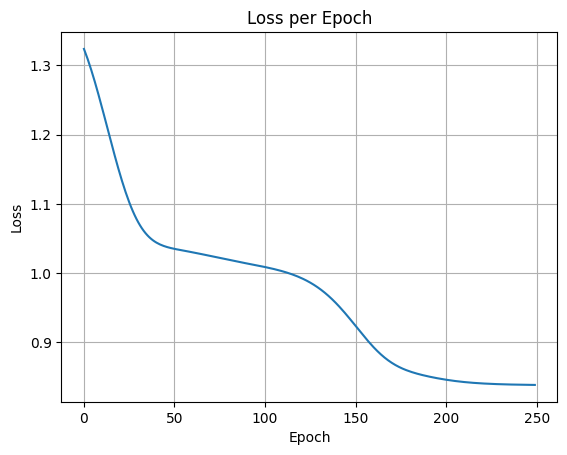

In [71]:
# Training loop
init_guesses = np.zeros((3,2))
model = BendModelN(init_guesses)#.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 250
epoch_list = []
loss_list = []

for epoch in range(epochs):
    optimiser.zero_grad()
    
    # Make output data
    fields_out = []
    for k in range(n):
        fields_out.append(model(fields_in[k]))
    #fields_out = np.array(fields_out)
    #fields_out = torch.from_numpy(fields_out)

    # Compute loss
    loss = loss_func(fields_out, fields_target)
    # Backwards pass
    loss.backward()
    optimiser.step()

    epoch_list.append(epoch)
    loss_list.append(loss.detach().item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Bend 1: {model.angles[0,0].item(), model.angles[0,1].item()}, Bend 2: {model.angles[1,0].item(), model.angles[1,1].item()}, Bend 3: {model.angles[2,0].item(), model.angles[2,1].item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final Bend 1: {model.angles[0,0].item(), model.angles[0,1].item()}")
print(f"Final Bend 2: {model.angles[1,0].item(), model.angles[1,1].item()}")
print(f"Final Bend 3: {model.angles[2,0].item(), model.angles[2,1].item()}")

plt.plot(epoch_list, loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.grid(visible=True)

# Check how field is changed visually
When travelling through a fibre with 3 bends, 4 propagation sections

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


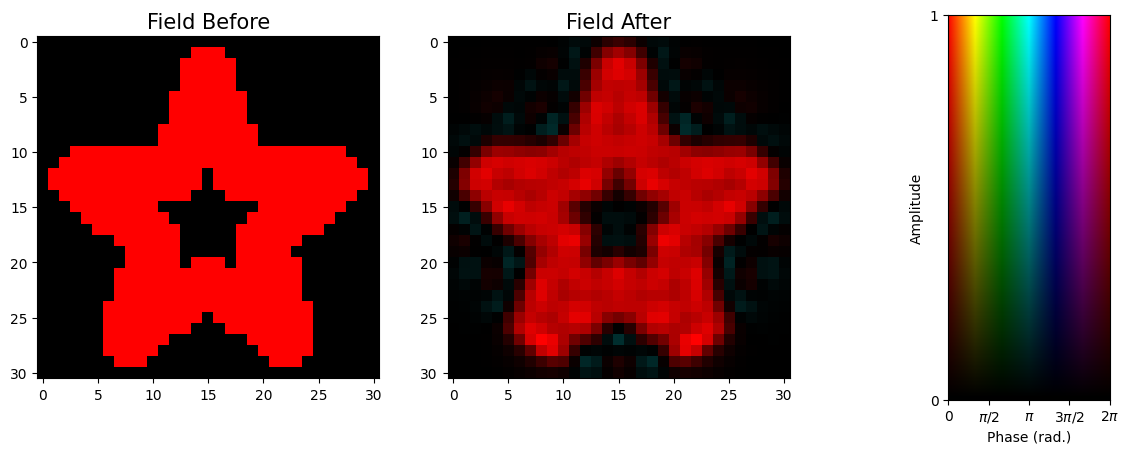

In [3]:
im = plt.imread("Images//Star1.png")
im_torch = torch.from_numpy(1 - im)[:,:,0]
im_torch = im_torch.to(dtype=torch.cdouble)
pim_im = propagate(im_torch, PIMs_torch, beta_torch)
visualise2(im_torch, pim_im)

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


tensor(0.0021005908, dtype=torch.float64)

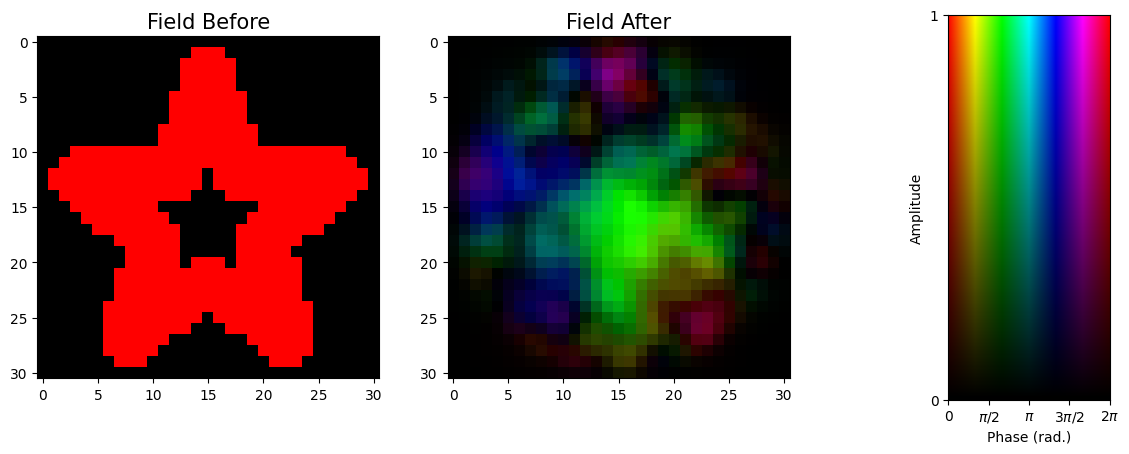

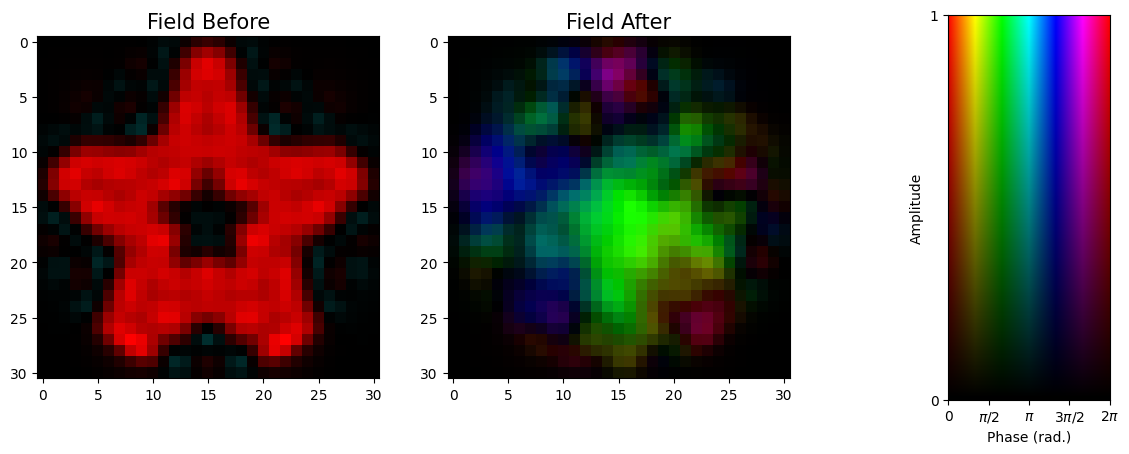

In [9]:
# Do input fields change the output depending on if it is already made up of PIMs or not?
angles = np.array([[0.5,0.5],[0.4,0.3],[0,0.6]])
model = BendModelN(angles)

test1 = model(im_torch).detach()
test2 = model(pim_im).detach()

visualise2(im_torch, test1)
visualise2(pim_im, test2)

# Difference between 2 output fields
(test1-test2).abs().square().sum()

# Effect of wrong TM on field
Using custom fields, see the visual and numerical effect using the wrong transmission matrix has on the field travelling through a fibre.

Train a model, taking the angles every 10 iterations, use these to make the TMs for the whole system, then compare how close the fields are using these TMs.

Couldn't figure out how to make a single TM for the system, for now just visually show the differences

In [31]:
# Angles
angles = np.array([[0.5,0.5],[0.4,0.3],[0,0.6]])
# Model
model = BendModelN(angles)

# Input fields
n = 5 # Number of fields
fields_in = PIMs_torch[:n]

# Make target fields
fields_target = []
for i in range(n):
    fields_target.append(model(fields_in[i]).detach())
fields_target = np.array(fields_target)
fields_target = torch.from_numpy(fields_target)

print(fields_in.shape)
print(fields_target.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'clone'

Epoch 0, Loss: 1.1315005676965062, Bend 1: (0.009999997913837433, 0.009999998845160007), Bend 2: (0.009999999776482582, -0.009999995119869709), Bend 3: (-0.009999998845160007, 0.009999998845160007)
Epoch 50, Loss: 0.0261981831292711, Bend 1: (0.46732088923454285, 0.4693731665611267), Bend 2: (0.42785441875457764, 0.29201173782348633), Bend 3: (0.060348812490701675, 0.5025103688240051)
Epoch 100, Loss: 0.00012118728745570757, Bend 1: (0.5045545101165771, 0.5014609694480896), Bend 2: (0.39718571305274963, 0.3004656434059143), Bend 3: (0.0005373458843678236, 0.6045336723327637)

Final Loss: 2.410609558135357e-07
Final Bend 1: (0.4999021291732788, 0.4999396502971649)
Final Bend 2: (0.3997105658054352, 0.30004268884658813)
Final Bend 3: (-0.00017741197370924056, 0.6000019311904907)


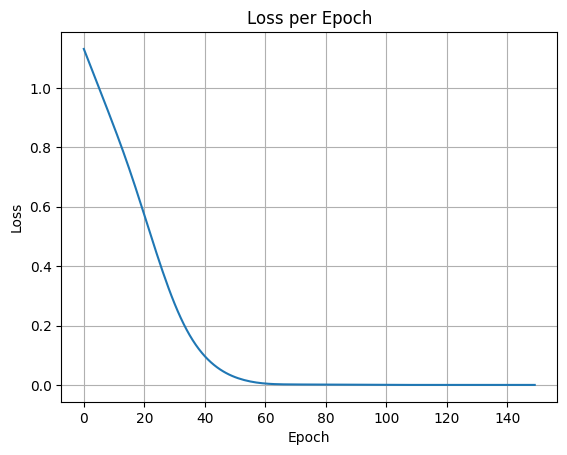

In [33]:
# Training loop
init_guesses = torch.zeros((3,2))
model = BendModelN(init_guesses)#.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 150
epoch_list = []
loss_list = []
angles_list = []

for epoch in range(epochs):
    optimiser.zero_grad()
    
    # Make output data
    fields_out = []
    for k in range(n):
        fields_out.append(model(fields_in[k]))
    #fields_out = np.array(fields_out)
    #fields_out = torch.from_numpy(fields_out)

    # Compute loss
    loss = loss_func(fields_out, fields_target)
    # Backwards pass
    loss.backward()
    optimiser.step()

    epoch_list.append(epoch)
    loss_list.append(loss.detach().item())

    if epoch % 10 == 0:
        data = []
        data1 = [model.angles[0,0].detach().item(), model.angles[0,1].detach().item()]
        data2 = [model.angles[1,0].detach().item(), model.angles[1,1].detach().item()]
        data3 = [model.angles[2,0].detach().item(), model.angles[2,1].detach().item()]
        data.append(torch.tensor([data1,data2,data3]))
        angles_list.append(data)
        #print(data)
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Bend 1: {model.angles[0,0].item(), model.angles[0,1].item()}, Bend 2: {model.angles[1,0].item(), model.angles[1,1].item()}, Bend 3: {model.angles[2,0].item(), model.angles[2,1].item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final Bend 1: {model.angles[0,0].item(), model.angles[0,1].item()}")
print(f"Final Bend 2: {model.angles[1,0].item(), model.angles[1,1].item()}")
print(f"Final Bend 3: {model.angles[2,0].item(), model.angles[2,1].item()}")

plt.plot(epoch_list, loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.grid(visible=True)

In [59]:
len(angles_list)
angles_list[1][0][0,0].item(), angles_list[1][0][0,1].item()

(0.10989922285079956, 0.11122305691242218)

Text(0.5, 1.0, 'Progagate 0.4m straight fibre')

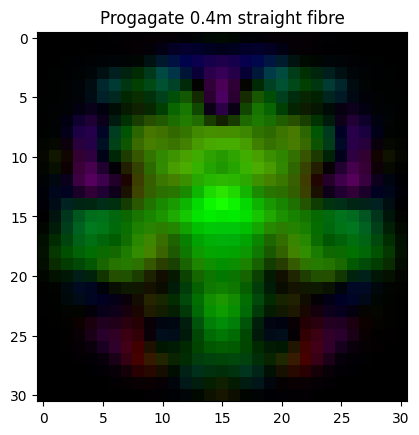

In [70]:
reg_prop = propagate(im_torch, PIMs_torch, beta_torch, 0.4)
plt.imshow(Complex2HSV(reg_prop))
plt.title("Progagate 0.4m straight fibre")

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:156: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


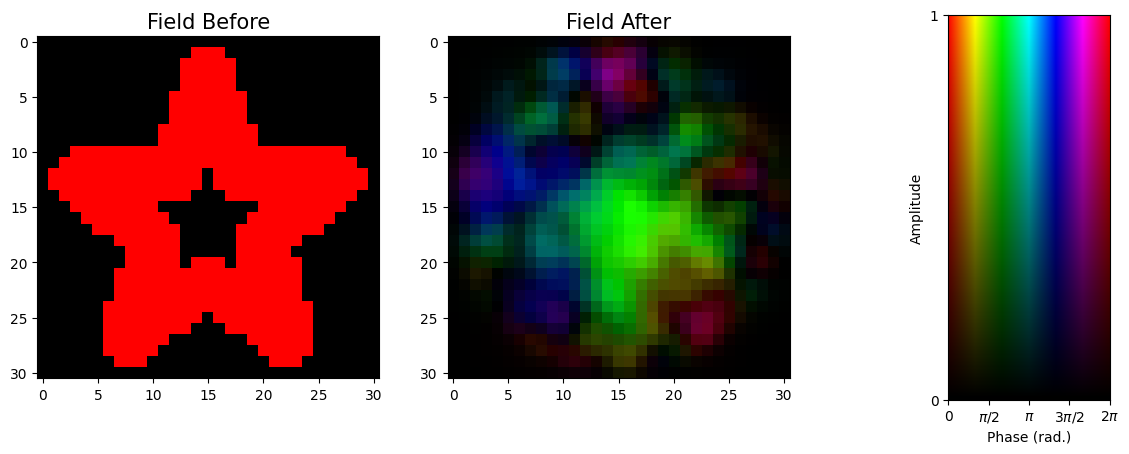

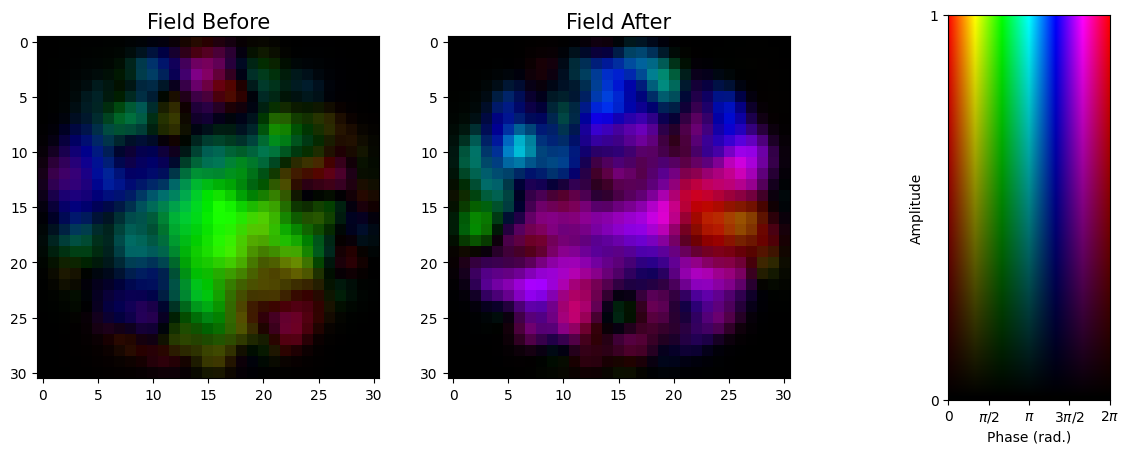

In [88]:
angles = torch.from_numpy(np.array([[0.5,0.5],[0.4,0.3],[0,0.6]]))
#angles = torch.zeros((3,2))
model = BendModelN(angles)

test1 = model(im_torch).detach()
visualise2(im_torch, test1)

angles = np.array([[-0,-0.6],[-0.4,-0.3],[-0.5,-0.5]])
angles = torch.from_numpy(angles)
model = BendModelN(angles)

test3 = model(test1).detach()
visualise2(test1, test3)

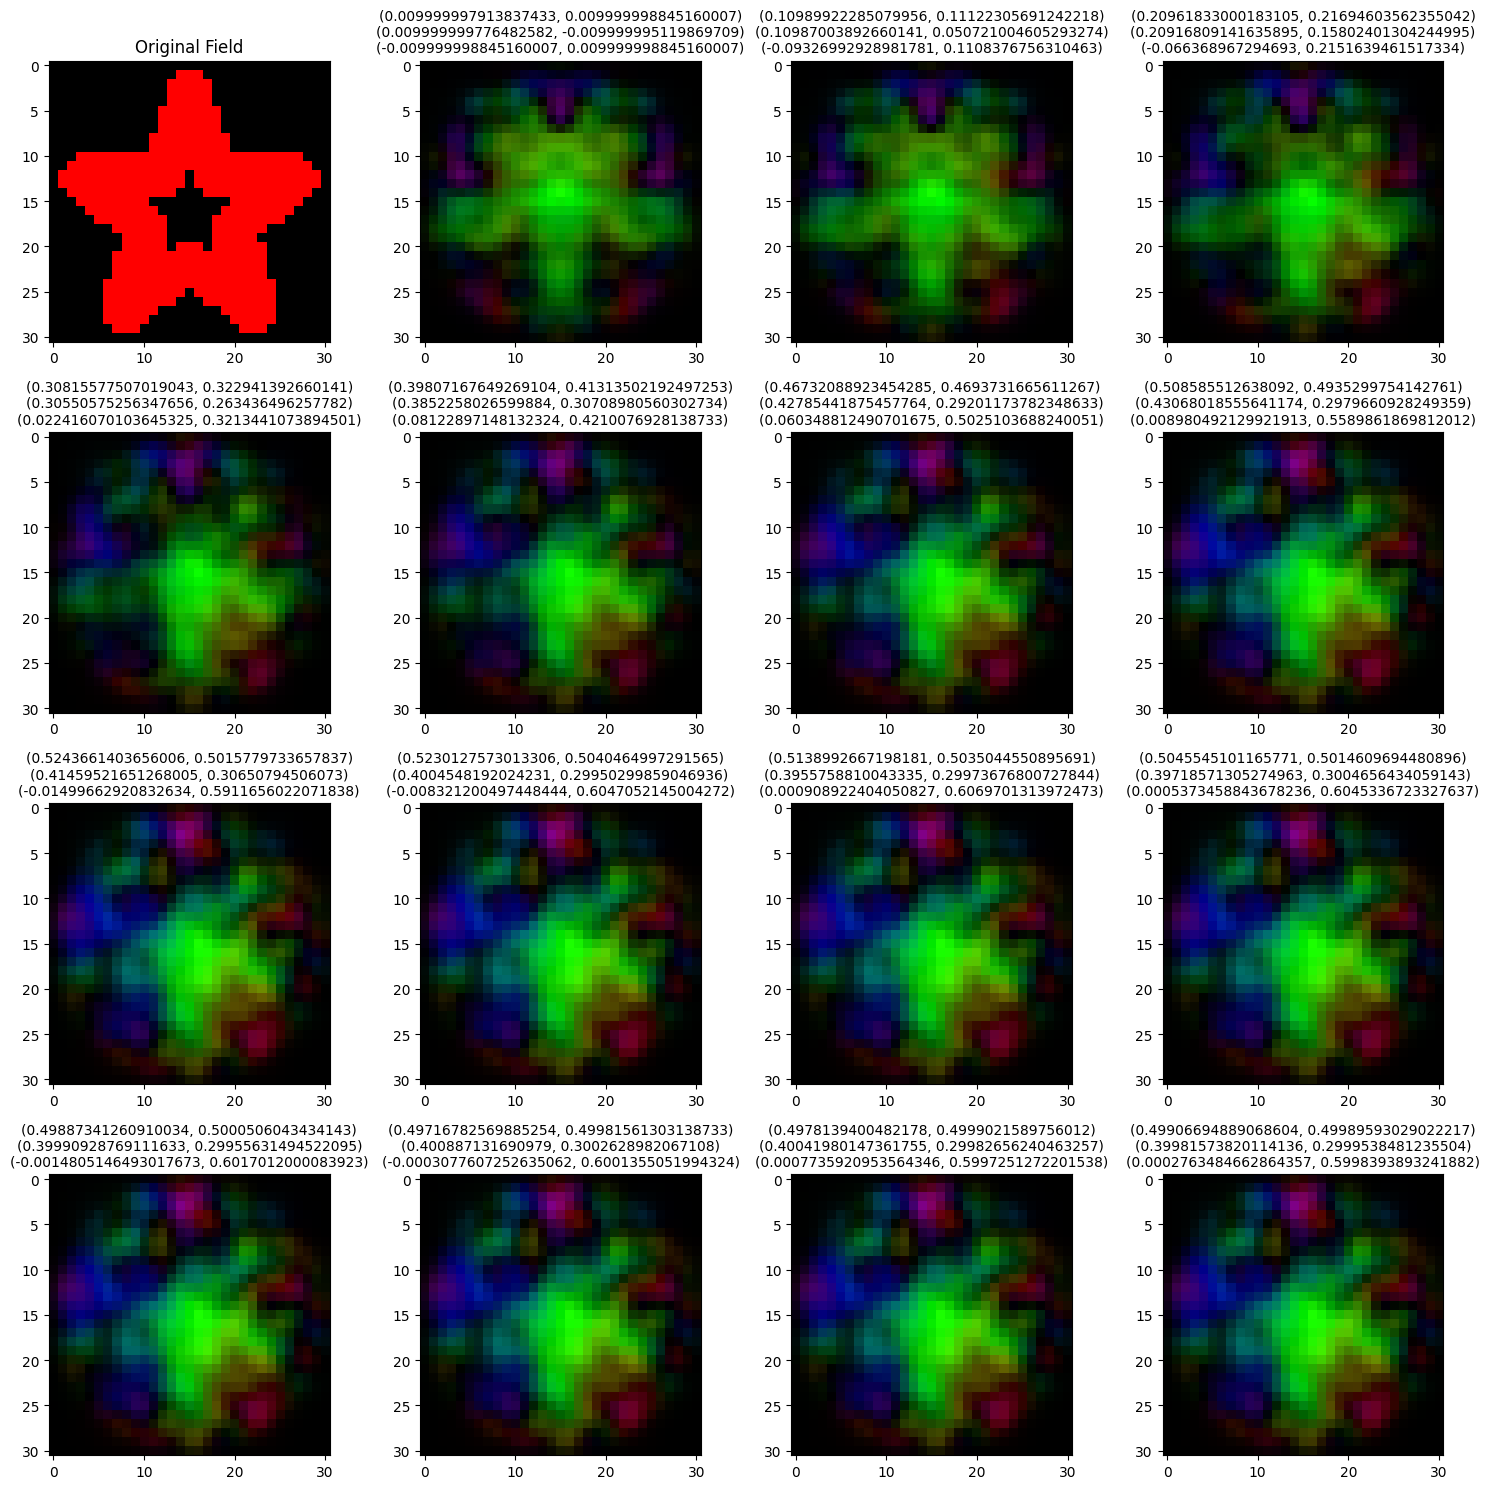

In [92]:
fig, axs = plt.subplots(4,4, figsize=(15,15))
ax = axs.flatten()
ax[0].imshow(Complex2HSV(im_torch))
ax[0].set_title(f"Original Field")


overlap = []
for i in range(len(angles_list)):
    model = BendModelN(angles_list[i][0])
    field_out = model(im_torch).detach()
    overlap.append(check_overlap(test1, field_out))

    ax[i+1].imshow(Complex2HSV(field_out))
    ax[i+1].set_title(f"{angles_list[i][0][0,0].item(), angles_list[i][0][0,1].item()}\n{angles_list[i][0][1,0].item(), angles_list[i][0][1,1].item()}\n{angles_list[i][0][2,0].item(), angles_list[i][0][2,1].item()}", fontsize=10)

plt.tight_layout()

Text(0.5, 1.0, 'True Field')

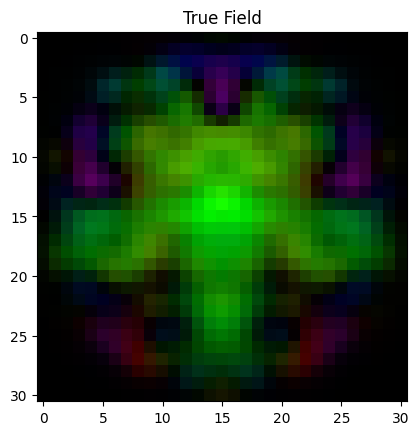

In [86]:
plt.imshow(Complex2HSV(test1))
plt.title("True Field")

In [91]:
def check_overlap(target, output):
    """words"""
    return (target - output).abs().square().sum().item()

In [93]:
overlap

[273.2346484368167,
 189.91719425393518,
 109.66246832014727,
 46.59555900806447,
 15.390480704267844,
 3.5960596847992727,
 0.7000690213182184,
 0.46754277480990514,
 0.2369523811823364,
 0.08916264867196097,
 0.015373002011767126,
 0.0015250041110324395,
 0.0030286299147051733,
 0.002059459765939028,
 0.0003829851599623577]

In [85]:
model = BendModelN(angles_list[14][0])
print(angles_list[14][0])
field_out = model(im_torch).detach()
check_overlap(im_torch, field_out)

tensor([[    0.4990669489,     0.4998959303],
        [    0.3998157382,     0.2999538481],
        [    0.0002763485,     0.5998393893]])


tensor(911.2712663271, dtype=torch.float64)